In [38]:
#Importing all the libraries
using SpecialFunctions
using LinearAlgebra
using DataFrames
using Plots
using ProgressMeter
using DelimitedFiles
theme(:ggplot2)

function scurve(x)
    return 1/(1 + exp(-11 * (x - 0.5)))
end

scurve (generic function with 1 method)

In [32]:
DOMINANT = false        #Switch between 1 being dominant or recessive
SHAPE = "s"

P = Dict(
    "pm" => 0.01,       #Proportion of 1 for male locus
    "pf" => 0.01,       #Proportion of 1 for female locus
    "C" => 20,          #Eggs laid by non functionender females
    "c" => 14,          #Eggs laid by functionender females
    "a" => 2,           #Advantege for non functionender males
    "u" => 0.1,         #Probability of female staying unmated
    "r" => 0.1          #Ratio of males in a female male mating
    )

function s(d, use = "exp")      #Probability of survival given the proportion of functionenders in the offsprings
    if use == "linear"
        return d * (0.9 - 0.1) + 0.1
    elseif use == "expinv"
        return ((exp(-d * 2.5) - exp(0))/(exp(-1 * 2.5) - exp(0))) * (0.9 - 0.1) + 0.1
    elseif use == "exp"
        return ((exp(2.5*d) - exp(0))/(exp(2.5) - exp(0))) * (0.9 - 0.1) + 0.1
    elseif use == "s"
        return ((scurve(d) - scurve(0)) / (scurve(1) - scurve(0))) * (0.9 - 0.1) + 0.1
    elseif use == "relu"
        return minimum(0.9, maximum(0.1, d^1.5))
    end
end

s (generic function with 2 methods)

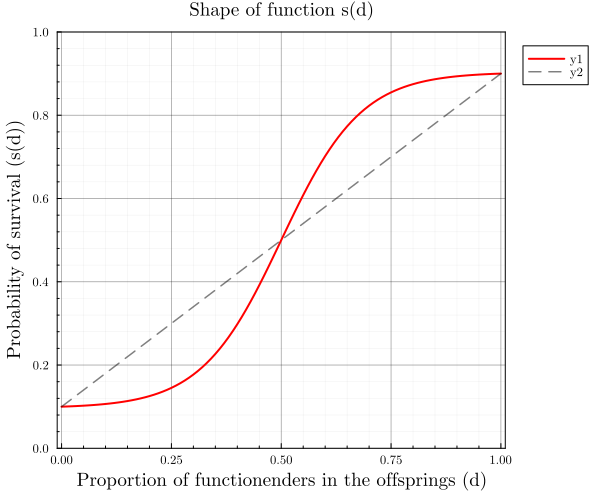

In [4]:
d = range(0, stop=1, length=101)
plot(d, s.(d, SHAPE), lw = 2, lc=:red, size = (600,500))
plot!(d, range(0.1, stop=0.9, length=101), linestyle=:dash, color=:black, alpha=0.5, lw = 1.5)
xlims!(-0.01,1.01)
ylims!(0.0, 1)
xlabel!("Proportion of functionenders in the offsprings (d)")
ylabel!("Probability of survival (s(d))")
title!("Shape of function s(d)")

In [5]:
#Modular functions for different loops
function F(u, f, m, c, S)
    return u * f * m * c * S
end

function S1(c, r)
    k = collect(0:c)
    S = sum(binomial.(c, k) .* (((r).^k).*((1-r).^(c.-k))) .* s.(k/c, SHAPE))
    return S
end

function S2(c, r1, r2, case = 1)
    if case == 1
        S = 0
        for k in 0:c
            mul1 = binomial.(c, k) * (((r1).^k).*((1-r1).^(c-k)))
            m = collect(0:k)
            Sm = sum(binomial.(k, m) .* (((r2).^m).*((1-r2).^(k.-m))) .* s.(m/c, SHAPE))
            S +=  mul1 * Sm
        end
    elseif case == 2
        S = 0
        for k in 0:c
            mul1 = binomial.(c, k) * (((r1).^k).*((1-r1).^(c-k)))
            m = collect(0:k)
            Sm = sum(binomial.(k, m) .* (((r2).^m).*((1-r2).^(k.-m))) .* s.((m .+ (c - k))/c, SHAPE))
            S +=  mul1 * Sm
        end
    end
    return S
end

function S3(c, r1, r2, r3)
    S = 0
    for k in 0:c
        mul1 = binomial.(c, k) * (((r1).^k).*((1-r1).^(c-k)))
        for m in 0:k
            mul2 = binomial.(k, m) * (((r2).^m).*((1-r2).^(k-m)))
            f = collect(0:c-k)
            Sf = sum(binomial.(c-k, f) .* (((r3).^f).*((1-r3).^(c-k.-f))) .* s.((f.+m)/c, SHAPE))
            S += mul1 * mul2 * Sf
        end
    end
    return S
end


S3 (generic function with 1 method)

In [6]:
#Functions to functionine mating interactions
#Non Matings
function f00(P)
    return F(P["u"], P["f00"], 1, P["C"], s(0, SHAPE))
end

function f01(P)
    return F(P["u"], P["f01"], 1, P["C"], S1(P["C"], 0.5))
end

function f02(P)
    return F(P["u"], P["f02"], 1, P["C"], s(1, SHAPE))
end

function f10(P)
    return F(P["u"], P["f10"], 1, DOMINANT ? P["c"] : P["C"], s(0, SHAPE))
end

function f11(P)
    return F(P["u"], P["f11"], 1, DOMINANT ? P["c"] : P["C"], S1(DOMINANT ? P["c"] : P["C"], 0.5))
end

function f12(P)
    return F(P["u"], P["f12"], 1, DOMINANT ? P["c"] : P["C"], s(1, SHAPE))
end

function f20(P)
    return F(P["u"], P["f20"], 1, P["c"], s(0, SHAPE))
end

function f21(P)
    return F(P["u"], P["f21"], 1, P["c"], S1(P["c"], 0.5))
end

function f22(P)
    return F(P["u"], P["f22"], 1, P["c"], s(1, SHAPE))
end


f22 (generic function with 1 method)

In [7]:
#Matings
#With m(00)
function f00m00(P)
    return F(1 - P["u"], P["f00"], P["m00"], P["C"], s(0, SHAPE))
end

function f01m00(P)
    return F(1 - P["u"], P["f01"], P["m00"], P["C"], S2(P["C"], P["r"], 0.5))
end

function f02m00(P)
    return F(1 - P["u"], P["f02"], P["m00"], P["C"], S1(P["C"], P["r"]))
end

function f10m00(P)
    return F(1 - P["u"], P["f10"], P["m00"], DOMINANT ? P["c"] : P["C"], DOMINANT ? S2(P["c"], 1-P["r"], 0.5) : s(0, SHAPE))
end

function f11m00(P)
    return F(1 - P["u"], P["f11"], P["m00"], DOMINANT ? P["c"] : P["C"],DOMINANT ? S3(P["c"], P["r"], 0.5, 0.5) : S2(P["C"], P["r"], 0.5))
end

function f12m00(P)
    return F(1 - P["u"], P["f12"], P["m00"], DOMINANT ? P["c"] : P["C"], DOMINANT ? S2(P["c"], 1-P["r"], 0.5, 2) : S1(P["C"], P["r"]))
end

function f20m00(P)
    return F(1 - P["u"], P["f20"], P["m00"], P["c"], DOMINANT ? S1(P["c"], 1-P["r"]) : s(0, SHAPE))
end

function f21m00(P)
    return F(1 - P["u"], P["f21"], P["m00"], P["c"], S2(P["c"], P["r"], 0.5, DOMINANT ? 2 : 1))
end

function f22m00(P)
    return F(1 - P["u"], P["f22"], P["m00"], P["c"], DOMINANT ? s(1, SHAPE) : S1(P["c"], P["r"]))
end

f22m00 (generic function with 1 method)

In [8]:
#Matings
#With m(01)
function f00m01(P)
    return F(1 - P["u"], P["f00"], P["m01"], P["C"], s(0, SHAPE))
end

function f01m01(P)
    return F(1 - P["u"], P["f01"], P["m01"], P["C"], S2(P["C"], P["r"], 0.5))
end

function f02m01(P)
    return F(1 - P["u"], P["f02"], P["m01"], P["C"], S1(P["C"], P["r"]))
end

function f10m01(P)
    return F(1 - P["u"], P["f10"], P["m01"], DOMINANT ? P["c"] : P["C"], DOMINANT ? S2(P["c"], 1-P["r"], 0.5) : s(0, SHAPE))
end

function f11m01(P)
    return F(1 - P["u"], P["f11"], P["m01"], DOMINANT ? P["c"] : P["C"],DOMINANT ? S3(P["c"], P["r"], 0.5, 0.5) : S2(P["C"], P["r"], 0.5))
end

function f12m01(P)
    return F(1 - P["u"], P["f12"], P["m01"], DOMINANT ? P["c"] : P["C"], DOMINANT ? S2(P["c"], 1-P["r"], 0.5, 2) : S1(P["C"], P["r"]))
end

function f20m01(P)
    return F(1 - P["u"], P["f20"], P["m01"], P["c"], DOMINANT ? S1(P["c"], 1-P["r"]) : s(0, SHAPE))
end

function f21m01(P)
    return F(1 - P["u"], P["f21"], P["m01"], P["c"], S2(P["c"], P["r"], 0.5, DOMINANT ? 2 : 1))
end

function f22m01(P)
    return F(1 - P["u"], P["f22"], P["m01"], P["c"], DOMINANT ? s(1, SHAPE) : S1(P["c"], P["r"]))
end

f22m01 (generic function with 1 method)

In [9]:
#Matings
#With m(10)
function f00m10(P)
    return F(1 - P["u"], P["f00"], P["m10"], P["C"], DOMINANT ? S1(P["C"], 1-P["r"]) : s(0, SHAPE))
end

function f01m10(P)
    return F(1 - P["u"], P["f01"], P["m10"], P["C"], S2(P["C"], P["r"], 0.5, DOMINANT ? 2 : 1))
end

function f02m10(P)
    return F(1 - P["u"], P["f02"], P["m10"], P["C"], DOMINANT ? s(1, SHAPE) : S1(P["C"], P["r"]))
end

function f10m10(P)
    return F(1 - P["u"], P["f10"], P["m10"], DOMINANT ? P["c"] : P["C"], DOMINANT ? S1(P["c"], 1-P["r"]) : S2(P["C"], 1-P["r"], 0.5))
end

function f11m10(P)
    return F(1 - P["u"], P["f11"], P["m10"], DOMINANT ? P["c"] : P["C"], DOMINANT ? S2(P["c"], P["r"], 0.5, 2) : S3(P["C"], P["r"], 0.5, 0.5))
end

function f12m10(P)
    return F(1 - P["u"], P["f12"], P["m10"], DOMINANT ? P["c"] : P["C"], DOMINANT ? s(1, SHAPE) : S2(P["C"], 1-P["r"], 0.5, 2))
end

function f20m10(P)
    return F(1 - P["u"], P["f20"], P["m10"], P["c"], S1(P["c"], 1-P["r"]))
end

function f21m10(P)
    return F(1 - P["u"], P["f21"], P["m10"], P["c"], S2(P["c"], P["r"], 0.5, 2))
end

function f22m10(P)
    return F(1 - P["u"], P["f22"], P["m10"], P["c"], s(1, SHAPE))
end

f22m10 (generic function with 1 method)

In [10]:
#Matings
#With m(11)
function f00m11(P)
    return F(1 - P["u"], P["f00"], P["m11"], P["C"], DOMINANT ? S1(P["C"], 1-P["r"]) : s(0, SHAPE))
end

function f01m11(P)
    return F(1 - P["u"], P["f01"], P["m11"], P["C"], S2(P["C"], P["r"], 0.5, DOMINANT ? 2 : 1))
end

function f02m11(P)
    return F(1 - P["u"], P["f02"], P["m11"], P["C"], DOMINANT ? s(1, SHAPE) : S1(P["C"], P["r"]))
end

function f10m11(P)
    return F(1 - P["u"], P["f10"], P["m11"], DOMINANT ? P["c"] : P["C"], DOMINANT ? S1(P["c"], 1-P["r"]) : S2(P["C"], 1-P["r"], 0.5))
end

function f11m11(P)
    return F(1 - P["u"], P["f11"], P["m11"], DOMINANT ? P["c"] : P["C"], DOMINANT ? S2(P["c"], P["r"], 0.5, 2) : S3(P["C"], P["r"], 0.5, 0.5))
end

function f12m11(P)
    return F(1 - P["u"], P["f12"], P["m11"], DOMINANT ? P["c"] : P["C"], DOMINANT ? s(1, SHAPE) : S2(P["C"], 1-P["r"], 0.5, 2))
end

function f20m11(P)
    return F(1 - P["u"], P["f20"], P["m11"], P["c"], S1(P["c"], 1-P["r"]))
end

function f21m11(P)
    return F(1 - P["u"], P["f21"], P["m11"], P["c"], S2(P["c"], P["r"], 0.5, 2))
end

function f22m11(P)
    return F(1 - P["u"], P["f22"], P["m11"], P["c"], s(1, SHAPE))
end

f22m11 (generic function with 1 method)

In [11]:
#Function to find the number of offsprings in the next generation based on all the interactions
function nexgen(P, females = [], males = [])
    #Initial frequencies of all genotypes
    if length(females) == 0 || length(males) == 0
        #Males
        m00 = (1 - P["pf"])*(1 - P["pm"])
        m01 = (1 - P["pf"])*P["pm"]
        m10 = P["pf"]*(1 - P["pm"])
        m11 = P["pf"]*P["pm"]

        tot_eff = ((m01 + m11) + (P["a"] * (m00 + m10)))

        P["m00"] = (P["a"] * m00) / tot_eff
        P["m01"] = m01 / tot_eff
        P["m10"] = (P["a"] * m10) / tot_eff
        P["m11"] = m11 / tot_eff

        #Females (Assuming equilibrium values)
        P["f00"] = ((1 - P["pf"])^2) * ((1 - P["pm"])^2)
        P["f01"] = ((1 - P["pf"])^2) * (2*P["pm"]*(1-P["pm"]))
        P["f02"] = ((1 - P["pf"])^2) * (P["pm"]^2)

        P["f10"] = (2*(1 - P["pf"])*P["pf"]) * ((1 - P["pm"])^2)
        P["f11"] = (2*(1 - P["pf"])*P["pf"]) * (2*P["pm"]*(1-P["pm"]))
        P["f12"] = (2*(1 - P["pf"])*P["pf"]) * (P["pm"]^2)

        P["f20"] = (P["pf"]^2) * ((1 - P["pm"])^2)
        P["f21"] = (P["pf"]^2) * (2*P["pm"]*(1-P["pm"]))
        P["f22"] = (P["pf"]^2) * (P["pm"]^2)


    else
        #Males
        m00 = males[1]
        m01 = males[2]
        m10 = males[3]
        m11 = males[4]

        tot_eff = ((m01 + m11) + (P["a"] * (m00 + m10)))

        P["m00"] = (P["a"] * m00) / tot_eff
        P["m01"] = m01 / tot_eff
        P["m10"] = (P["a"] * m10) / tot_eff
        P["m11"] = m11 / tot_eff

        #Females (Assuming equilibrium values)
        P["f00"] = females[1]
        P["f01"] = females[2]
        P["f02"] = females[3]
        
        P["f10"] = females[4]
        P["f11"] = females[5]
        P["f12"] = females[6]

        P["f20"] = females[7]
        P["f21"] = females[8]
        P["f22"] = females[9]
    end



    #Next Generation
    #Females
    f00_n = (1 - P["r"]) * (f00m00(P) + 0.5 * (f01m00(P) + f10m00(P) + 0.5 * f11m00(P)))

    f01_n = (1 - P["r"]) * (f00m01(P) + f02m00(P) + 0.5 * (f01m00(P) + f01m01(P) + f10m01(P) + f12m00(P) + 0.5 * (f11m00(P) + f11m01(P))))

    f02_n = (1 - P["r"]) * (f02m01(P) + 0.5 * (f01m01(P) + f12m01(P) + 0.5 * f11m01(P)))

    f10_n = (1 - P["r"]) * (f00m10(P) + f20m00(P) + 0.5 * (f01m10(P) + f21m00(P) + f10m00(P) + f10m10(P) + 0.5 * (f11m00(P) + f11m10(P))))

    f11_n = (1 - P["r"]) * (f00m11(P) + f02m10(P) + f20m01(P) + f22m00(P) + 0.5 * (f01m10(P) + f01m11(P) + f21m00(P) + f21m01(P) + f10m01(P) + f10m11(P) + f12m00(P) + f12m10(P) + 0.5 * (f11m00(P) + f11m01(P) + f11m10(P) + f11m11(P))))

    f12_n = (1 - P["r"]) * (f02m11(P) + f22m01(P) + 0.5 * (f01m11(P) + f21m01(P) + f12m01(P) + f12m11(P) + 0.5 * (f11m01(P) + f11m11(P))))

    f20_n = (1 - P["r"]) * (f20m10(P) + 0.5 * (f21m10(P) + f10m10(P) + 0.5 * f11m10(P)))

    f21_n = (1 - P["r"]) * (f20m11(P) + f22m10(P) + 0.5 * (f21m10(P) + f21m11(P) + f10m11(P) + f12m10(P) + 0.5 * (f11m10(P) + f11m11(P))))

    f22_n = (1 - P["r"]) * (f22m11(P) + 0.5 * (f21m11(P) + f12m11(P) + 0.5 * f11m11(P)))


    #Males
    m00_n = f00(P) + 0.5 * (f01(P) + f10(P) + 0.5 * f11(P)) + P["r"] * ((f00m00(P) + f00m01(P) + f00m10(P) + f00m11(P)) + 0.5 * ((f01m00(P) + f01m01(P) + f01m10(P) + f01m11(P)) + (f10m00(P) + f10m01(P) + f10m10(P) + f10m11(P)) + 0.5 * (f11m00(P) + f11m01(P) + f11m10(P) + f11m11(P))))

    m01_n = f02(P) + 0.5 * (f01(P) + f12(P) + 0.5 * f11(P)) + P["r"] * ((f02m00(P) + f02m01(P) + f02m10(P) + f02m11(P)) + 0.5 * ((f01m00(P) + f01m01(P) + f01m10(P) + f01m11(P)) + (f12m00(P) + f12m01(P) + f12m10(P) + f12m11(P)) + 0.5 * (f11m00(P) + f11m01(P) + f11m10(P) + f11m11(P))))
    
    m10_n = f20(P) + 0.5 * (f21(P) + f10(P) + 0.5 * f11(P)) + P["r"] * ((f20m00(P) + f20m01(P) + f20m10(P) + f20m11(P)) + 0.5 * ((f21m00(P) + f21m01(P) + f21m10(P) + f21m11(P)) + (f10m00(P) + f10m01(P) + f10m10(P) + f10m11(P)) + 0.5 * (f11m00(P) + f11m01(P) + f11m10(P) + f11m11(P))))
    
    m11_n = f22(P) + 0.5 * (f21(P) + f12(P) + 0.5 * f11(P)) + P["r"] * ((f22m00(P) + f22m01(P) + f22m10(P) + f22m11(P)) + 0.5 * ((f21m00(P) + f21m01(P) + f21m10(P) + f21m11(P)) + (f12m00(P) + f12m01(P) + f12m10(P) + f12m11(P)) + 0.5 * (f11m00(P) + f11m01(P) + f11m10(P) + f11m11(P))))


    #Creating a list for number of all organisms in next generation
    female_ls = [f00_n, f01_n, f02_n, f10_n, f11_n, f12_n, f20_n, f21_n, f22_n]
    male_ls = [m00_n, m01_n, m10_n, m11_n]

    return female_ls, male_ls
end

nexgen (generic function with 3 methods)

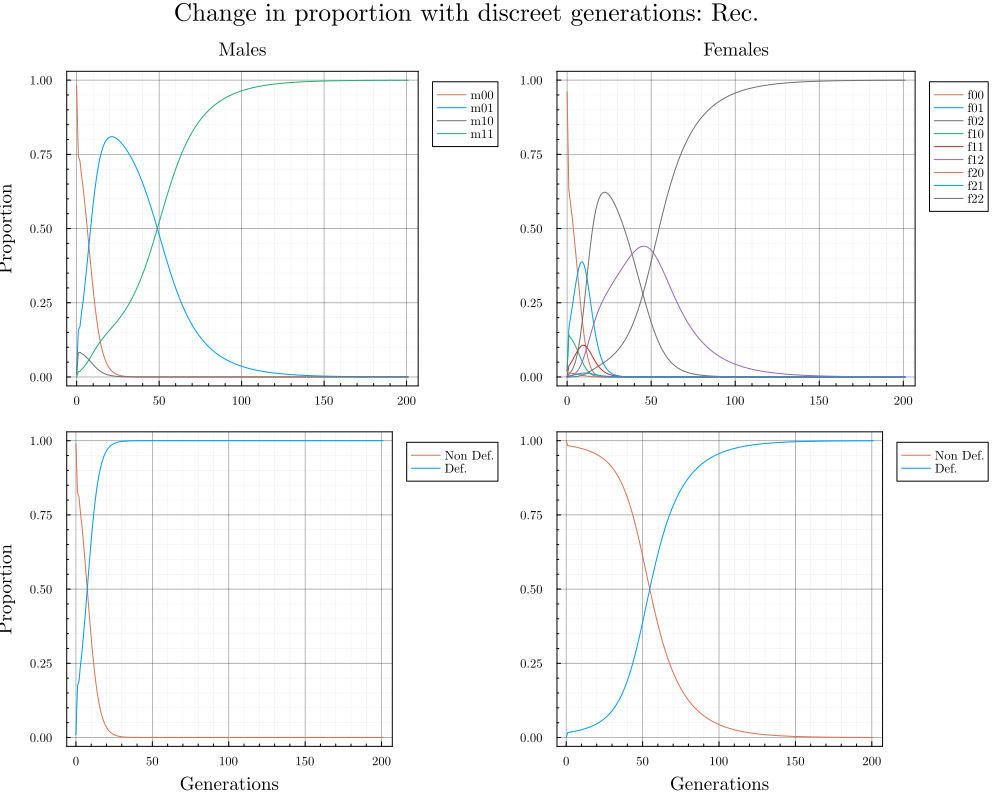

In [12]:
#Simulating proportions of each individual over a generation time
DOMINANT = false
SHAPE = "exp"
#Dominant case
gentime = 200

param = copy(P)
param["pm"] = 0.1
param["pf"] = 0.1

param["c"] = 8
param["a"] = 1.5

param["u"] = 0.1
param["r"] = (2 - param["u"]) / 4

females = []
males = []

ind_prop = Dict(
    "m00" => [(1 - P["pf"])*(1 - P["pm"])],
    "m01" => [(1 - P["pf"])*(P["pm"])],
    "m10" => [(P["pf"])*(1 - P["pm"])],
    "m11" => [(P["pf"])*(P["pm"])],

    "f00" => [((1 - P["pf"])^2) * ((1 - P["pm"])^2)],
    "f01" => [((1 - P["pf"])^2) * (P["pm"] * (1 - P["pm"]) * 2)],
    "f02" => [((1 - P["pf"])^2) * ((P["pm"])^2)],

    "f10" => [(P["pf"] * (1 - P["pf"]) * 2) * ((1 - P["pm"])^2)],
    "f11" => [(P["pf"] * (1 - P["pf"]) * 2) * (P["pm"] * (1 - P["pm"]) * 2)],
    "f12" => [(P["pf"] * (1 - P["pf"]) * 2) * ((P["pm"])^2)],

    "f20" => [((P["pf"])^2) * ((1 - P["pm"])^2)],
    "f21" => [((P["pf"])^2) * (P["pm"] * (1 - P["pm"]) * 2)],
    "f22" => [((P["pf"])^2) * ((P["pm"])^2)]
)

for t in 0:gentime
    female_ls, male_ls = nexgen(param, females, males)

    push!(ind_prop["m00"], male_ls[1] / sum(male_ls))
    push!(ind_prop["m01"], male_ls[2] / sum(male_ls))
    push!(ind_prop["m10"], male_ls[3] / sum(male_ls))
    push!(ind_prop["m11"], male_ls[4] / sum(male_ls))

    push!(ind_prop["f00"], female_ls[1] / sum(female_ls))
    push!(ind_prop["f01"], female_ls[2] / sum(female_ls))
    push!(ind_prop["f02"], female_ls[3] / sum(female_ls))

    push!(ind_prop["f10"], female_ls[4] / sum(female_ls))
    push!(ind_prop["f11"], female_ls[5] / sum(female_ls))
    push!(ind_prop["f12"], female_ls[6] / sum(female_ls))

    push!(ind_prop["f20"], female_ls[7] / sum(female_ls))
    push!(ind_prop["f21"], female_ls[8] / sum(female_ls))
    push!(ind_prop["f22"], female_ls[9] / sum(female_ls))

    females = female_ls ./ sum(female_ls)
    males = male_ls ./ sum(male_ls)
end


rng = collect(0:gentime+1)
p1 = plot(rng, [ind_prop["m00"] ind_prop["m01"] ind_prop["m10"] ind_prop["m11"]], labels = ["m00" "m01" "m10" "m11"], lw = 1, ylabel = "Proportion", title = "Males")
p2 = plot(rng, [ind_prop["f00"] ind_prop["f01"] ind_prop["f02"] ind_prop["f10"] ind_prop["f11"] ind_prop["f12"] ind_prop["f20"] ind_prop["f21"] ind_prop["f22"]], labels = ["f00" "f01" "f02" "f10" "f11" "f12" "f20" "f21" "f22"], lw = 1, title = "Females")
p3 = plot(rng, [(ind_prop["m00"] .+ ind_prop["m10"]) (ind_prop["m11"] .+ ind_prop["m01"])], labels = ["Non Def." "Def."], lw = 1, xlabel = "Generations", ylabel = "Proportion")
prec = plot(rng, [(ind_prop["f00"] .+ ind_prop["f01"] .+ ind_prop["f02"] .+ ind_prop["f10"] .+ ind_prop["f11"] .+ ind_prop["f12"]) (ind_prop["f20"] .+ ind_prop["f21"] .+ ind_prop["f22"])], labels = ["Non Def." "Def."], lw = 1, xlabel = "Generations")
pdom = plot(rng, [(ind_prop["f00"] .+ ind_prop["f01"] .+ ind_prop["f02"]) (ind_prop["f10"] .+ ind_prop["f11"] .+ ind_prop["f12"] .+ ind_prop["f20"] .+ ind_prop["f21"] .+ ind_prop["f22"])], labels = ["Non Def." "Def."], lw = 1, xlabel = "Generations")

plot(p1, p2, p3, DOMINANT ? pdom : prec, layout = (2,2), size = (1000,800), plot_title = string("Change in proportion with discreet generations: ", DOMINANT ? "Dom." : "Rec."))

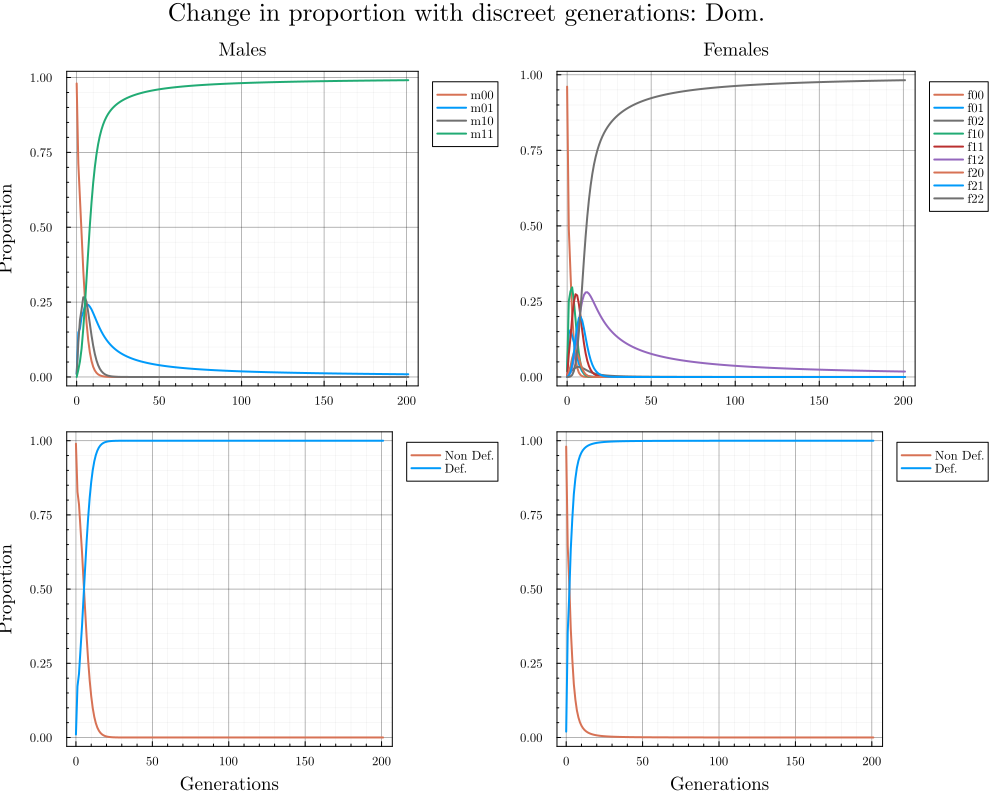

In [13]:
#Simulating proportions of each individual over a generation time
DOMINANT = true
SHAPE = "exp"
#Dominant case
gentime = 200

param = copy(P)
param["pm"] = 0.1
param["pf"] = 0.1

param["c"] = 20
param["a"] = 1

param["u"] = 0.1
param["r"] = (2 - param["u"]) / 4

females = []
males = []

ind_prop = Dict(
    "m00" => [(1 - P["pf"])*(1 - P["pm"])],
    "m01" => [(1 - P["pf"])*(P["pm"])],
    "m10" => [(P["pf"])*(1 - P["pm"])],
    "m11" => [(P["pf"])*(P["pm"])],

    "f00" => [((1 - P["pf"])^2) * ((1 - P["pm"])^2)],
    "f01" => [((1 - P["pf"])^2) * (P["pm"] * (1 - P["pm"]) * 2)],
    "f02" => [((1 - P["pf"])^2) * ((P["pm"])^2)],

    "f10" => [(P["pf"] * (1 - P["pf"]) * 2) * ((1 - P["pm"])^2)],
    "f11" => [(P["pf"] * (1 - P["pf"]) * 2) * (P["pm"] * (1 - P["pm"]) * 2)],
    "f12" => [(P["pf"] * (1 - P["pf"]) * 2) * ((P["pm"])^2)],

    "f20" => [((P["pf"])^2) * ((1 - P["pm"])^2)],
    "f21" => [((P["pf"])^2) * (P["pm"] * (1 - P["pm"]) * 2)],
    "f22" => [((P["pf"])^2) * ((P["pm"])^2)]
)

for t in 0:gentime
    female_ls, male_ls = nexgen(param, females, males)

    push!(ind_prop["m00"], male_ls[1] / sum(male_ls))
    push!(ind_prop["m01"], male_ls[2] / sum(male_ls))
    push!(ind_prop["m10"], male_ls[3] / sum(male_ls))
    push!(ind_prop["m11"], male_ls[4] / sum(male_ls))

    push!(ind_prop["f00"], female_ls[1] / sum(female_ls))
    push!(ind_prop["f01"], female_ls[2] / sum(female_ls))
    push!(ind_prop["f02"], female_ls[3] / sum(female_ls))

    push!(ind_prop["f10"], female_ls[4] / sum(female_ls))
    push!(ind_prop["f11"], female_ls[5] / sum(female_ls))
    push!(ind_prop["f12"], female_ls[6] / sum(female_ls))

    push!(ind_prop["f20"], female_ls[7] / sum(female_ls))
    push!(ind_prop["f21"], female_ls[8] / sum(female_ls))
    push!(ind_prop["f22"], female_ls[9] / sum(female_ls))

    females = female_ls ./ sum(female_ls)
    males = male_ls ./ sum(male_ls)
end


rng = collect(0:gentime+1)
p1 = plot(rng, [ind_prop["m00"] ind_prop["m01"] ind_prop["m10"] ind_prop["m11"]], labels = ["m00" "m01" "m10" "m11"], lw = 2, ylabel = "Proportion", title = "Males")
p2 = plot(rng, [ind_prop["f00"] ind_prop["f01"] ind_prop["f02"] ind_prop["f10"] ind_prop["f11"] ind_prop["f12"] ind_prop["f20"] ind_prop["f21"] ind_prop["f22"]], labels = ["f00" "f01" "f02" "f10" "f11" "f12" "f20" "f21" "f22"], lw = 2, title = "Females")
p3 = plot(rng, [(ind_prop["m00"] .+ ind_prop["m10"]) (ind_prop["m11"] .+ ind_prop["m01"])], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations", ylabel = "Proportion")
prec = plot(rng, [(ind_prop["f00"] .+ ind_prop["f01"] .+ ind_prop["f02"] .+ ind_prop["f10"] .+ ind_prop["f11"] .+ ind_prop["f12"]) (ind_prop["f20"] .+ ind_prop["f21"] .+ ind_prop["f22"])], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations")
pdom = plot(rng, [(ind_prop["f00"] .+ ind_prop["f01"] .+ ind_prop["f02"]) (ind_prop["f10"] .+ ind_prop["f11"] .+ ind_prop["f12"] .+ ind_prop["f20"] .+ ind_prop["f21"] .+ ind_prop["f22"])], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations")

plot(p1, p2, p3, DOMINANT ? pdom : prec, layout = (2,2), size = (1000,800), plot_title = string("Change in proportion with discreet generations: ", DOMINANT ? "Dom." : "Rec."))

In [16]:
function prop_plot(P, u)
    range_c = collect(1:1:20)
    range_a = round.(collect(range(1, 3, 20)), digits = 2)

    param = copy(P)
    param["pm"] = 0.1
    param["pf"] = 0.1

    param["u"] = u
    param["r"] = (2 - param["u"]) / 4

    gentime = 200

    female_data = []
    male_data = []
    total_data = []

    @showprogress 1 "Computing...." for i in range_a
        female_data_a = []
        male_data_a = []
        total_data_a = []

        param["a"] = i
        for j in range_c
            param["c"] = j

            females = []
            males = []

            female_ls = []
            male_ls = []
            for t in 0:gentime
                female_ls, male_ls = nexgen(param, females, males)

                females = copy(female_ls)
                males = copy(male_ls)

                females = females ./ (sum(females))
                males = males ./ (sum(males))
            end
                    
            if DOMINANT
                total_def = (male_ls[2] + male_ls[4] + sum(female_ls[4:end])) / (sum(male_ls) + sum(female_ls))
                male_def = (male_ls[2] + male_ls[4]) / sum(male_ls)
                female_def = sum(female_ls[4:end]) / sum(female_ls)
            else
                total_def = (male_ls[2] + male_ls[4] + sum(female_ls[7:end])) / (sum(male_ls) + sum(female_ls))
                male_def = (male_ls[2] + male_ls[4]) / sum(male_ls)
                female_def = sum(female_ls[7:end]) / sum(female_ls)
            end
                
            push!(female_data_a, female_def)
            push!(male_data_a, male_def)
            push!(total_data_a, total_def)
        
        end
        push!(female_data, female_data_a)
        push!(male_data, male_data_a)
        push!(total_data, total_data_a)
    
    end

    return hcat(female_data...), hcat(male_data...), hcat(total_data...)
end

prop_plot (generic function with 1 method)

In [17]:
SHAPE = "exp"
DOMINANT = true
f_dom, m_dom, t_dom = prop_plot(P, 0.1)
DOMINANT = false
f_rec, m_rec, t_rec = prop_plot(P, 0.1)

Computing....  10%|████                                  |  ETA: 0:06:23

Computing....  15%|██████                                |  ETA: 0:05:58

Computing....  20%|████████                              |  ETA: 0:05:36

Computing....  25%|██████████                            |  ETA: 0:05:15

Computing....  30%|████████████                          |  ETA: 0:04:54

Computing....  35%|██████████████                        |  ETA: 0:04:33

Computing....  40%|████████████████                      |  ETA: 0:04:11

Computing....  45%|██████████████████                    |  ETA: 0:03:50

Computing....  50%|████████████████████                  |  ETA: 0:03:29

Computing....  55%|█████████████████████                 |  ETA: 0:03:09

Computing....  60%|███████████████████████               |  ETA: 0:02:47

Computing....  65%|█████████████████████████             |  ETA: 0:02:26

Computing....  70%|███████████████████████████           |  ETA: 0:02:04

Computing....  75%|█████████████████████████████         |  ETA: 0:01:43

Computing....  80%|███████████████████████████████       |  ETA: 0:01:22

Computing....  85%|█████████████████████████████████     |  ETA: 0:01:02

Computing....  90%|███████████████████████████████████   |  ETA: 0:00:41

Computing....  95%|█████████████████████████████████████ |  ETA: 0:00:20

Computing.... 100%|██████████████████████████████████████| Time: 0:06:48


Computing....  10%|████                                  |  ETA: 0:13:17

Computing....  15%|██████                                |  ETA: 0:12:33

Computing....  20%|████████                              |  ETA: 0:11:48

Computing....  25%|██████████                            |  ETA: 0:11:04

Computing....  30%|████████████                          |  ETA: 0:10:20

Computing....  35%|██████████████                        |  ETA: 0:09:36

Computing....  40%|████████████████                      |  ETA: 0:08:52

Computing....  45%|██████████████████                    |  ETA: 0:08:11

Computing....  50%|████████████████████                  |  ETA: 0:07:25

Computing....  55%|█████████████████████                 |  ETA: 0:06:39

Computing....  60%|███████████████████████               |  ETA: 0:05:55

Computing....  65%|█████████████████████████             |  ETA: 0:05:10

Computing....  75%|█████████████████████████████         |  ETA: 0:03:41

Computing....  80%|███████████████████████████████       |  ETA: 0:02:57

Computing....  85%|█████████████████████████████████     |  ETA: 0:02:12

Computing....  90%|███████████████████████████████████   |  ETA: 0:01:28

Computing....  95%|█████████████████████████████████████ |  ETA: 0:00:44

Computing.... 100%|██████████████████████████████████████| Time: 0:14:43


([0.0009911573333341885 0.0009914351421722 … 0.0010508664140809975 0.0010748903051129516; 0.0017865949523459522 0.0017869803737133754 … 0.0018868262862038192 0.001925878763793882; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0], [1.0 1.0 … 0.9617312158215006 0.8466106538252703; 1.0 1.0 … 0.9615699965548529 0.8463285459280346; … ; 1.0 1.0 … 0.7045460318991132 0.6114091701738736; 1.0 1.0 … 0.7095467898600094 0.6155417098141739], [0.6162756260241107 0.6162757059927857 … 0.5884025971921201 0.5071246121039462; 0.6165053412173561 0.6165054524024551 … 0.5885366891321416 0.5072111699054542; … ; 1.0 1.0 … 0.8478735908553029 0.8012870361162023; 1.0 1.0 … 0.8503927594956794 0.8033428892191709])

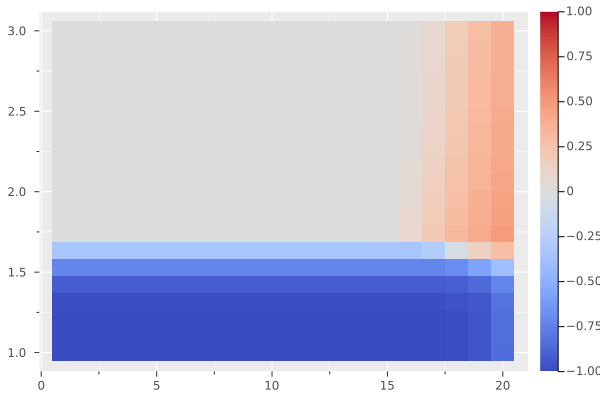

In [29]:
range_c = collect(1:1:20)
range_a = round.(collect(range(1, 3, 20)), digits = 2)

heatmap(range_c, range_a, round.(f_rec .- m_rec, digits = 2), color = :coolwarm, clim = (-1.0,1.0))

In [40]:
writedlm("DataCSVs/f_dom_exp.csv", f_dom)
writedlm("DataCSVs/m_dom_exp.csv", m_dom)
writedlm("DataCSVs/t_dom_exp.csv", t_dom)
writedlm("DataCSVs/f_rec_exp.csv", f_rec)
writedlm("DataCSVs/m_rec_exp.csv", m_rec)
writedlm("DataCSVs/t_rec_exp.csv", t_rec)
